In [1]:
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

In [2]:
from easydict import EasyDict
import pickle

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
from tabulate import tabulate

In [3]:
def nice_results(results):
    if isinstance(results, str):
        with open(results, 'rb') as sfile:
            results = pickle.load(sfile)

    plt.figure(figsize=(6, 2))
    for (internal_id, map_size), save_dict in results.items():
        save_dict = EasyDict(save_dict)

        fr, nr = save_dict.fr, save_dict.nr        
        plt.scatter(fr, nr, s=0.5)
        plt.xlabel('rpe')
        plt.ylabel('mom')

    corrs = []
    all_fr = sum((save_dict['fr'] for save_dict in results.values()), [])
    all_nr = sum((save_dict['nr'] for save_dict in results.values()), [])

    for corr_func in [pearsonr, spearmanr, kendalltau]:
        corr = corr_func(all_fr, all_nr)
        corr = corr.statistic if hasattr(corr, "statistic") else corr.correlation
        corrs.append(corr * 100)
    print(corrs)

    return results

# Быстрый взгляд на результаты

In [24]:
voxel_sizes = [0.2, 0.3, 0.4, 0.6, 0.8, 1.0, 1.5]

[99.63613806538437, 99.34116635279807, 94.02368957303928]
[99.62645798074381, 99.31083115143682, 93.9065213534134]
[99.64680985272813, 99.48151277573413, 94.84967390544604]
[99.01597478136576, 98.85817698282905, 91.68144352623005]
[98.71756067948738, 98.94567888534532, 91.87448720085598]
[98.20125067226714, 98.09679308119073, 89.2277500282275]
[98.53727034058976, 98.56212847470024, 90.98591852206314]


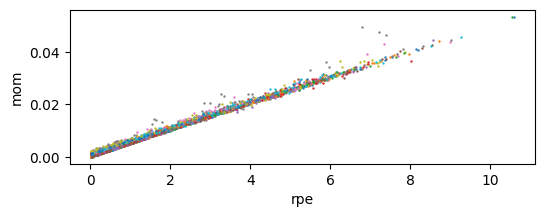

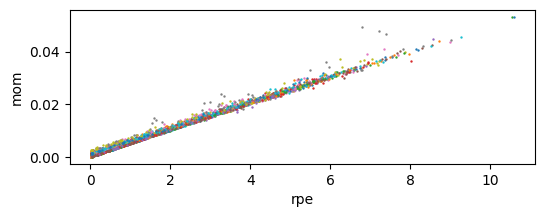

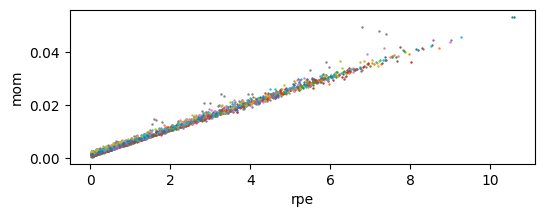

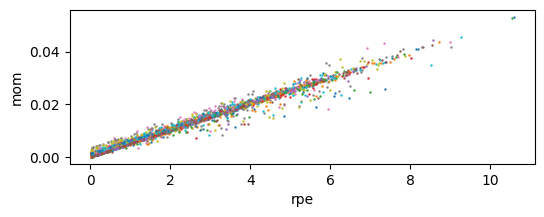

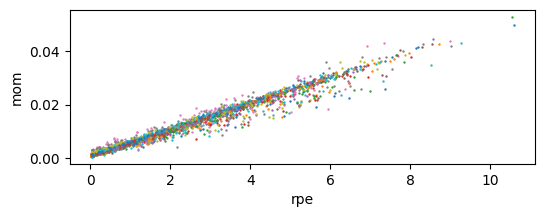

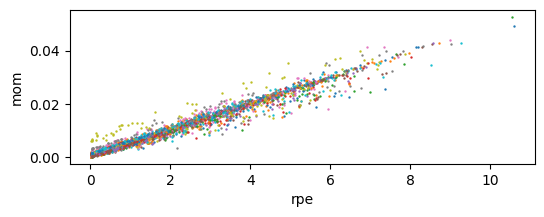

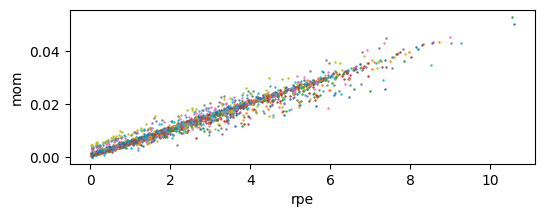

In [25]:
DU = [
    nice_results(f"CARLA-downsampling_upsampling_vs{vs}.pkl")
    for vs in voxel_sizes
]

[99.65603823807882, 99.30948297853736, 93.90462876836804]
[99.63196780339811, 99.20572991668823, 93.5436611842636]
[99.62744963794529, 99.2760915069395, 93.92019958169571]
[98.70823001852504, 98.50731955352472, 90.35818247315703]
[98.2327736336451, 98.22513706034137, 89.02597465441507]
[97.23479144455983, 97.0863320370714, 86.97746640930379]
[97.72456110457446, 97.54148546007045, 87.51160552505794]


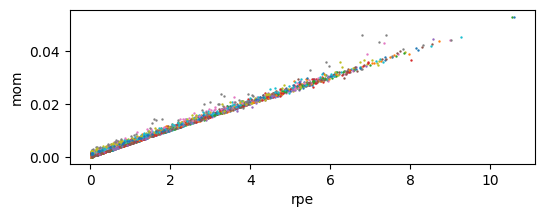

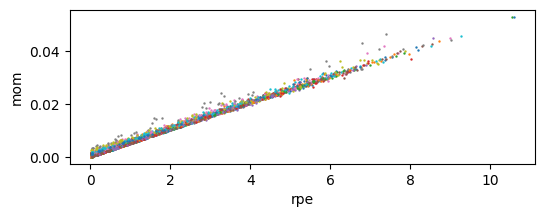

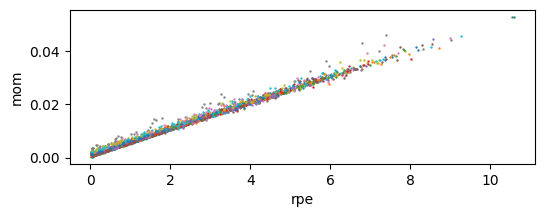

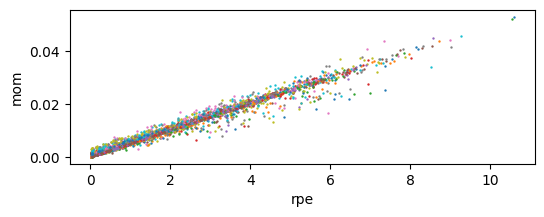

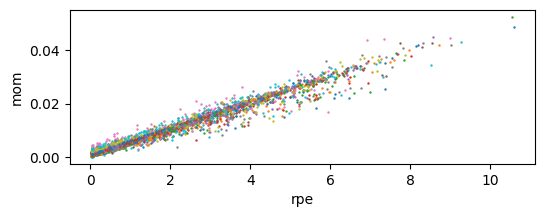

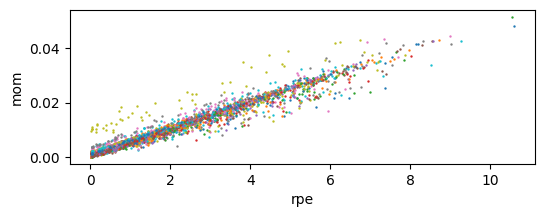

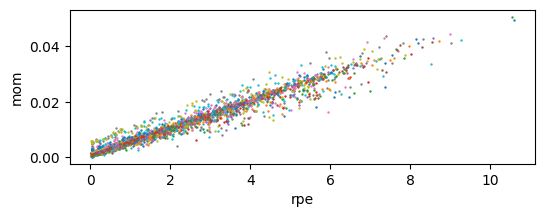

In [26]:
D = [
    nice_results(f"CARLA-downsampling_vs{vs}.pkl")
    for vs in voxel_sizes
]

[99.6177423783375, 99.30705029536405, 93.91366156062995]


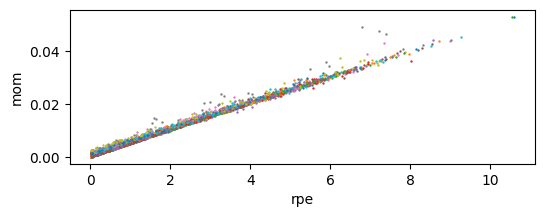

In [32]:
base = nice_results("CARLA-cosine-affinity-orth-planes_v1.pkl");

In [133]:
ALL = [base, *DU, *D]

In [176]:
Bt = """32:01"""

DUt = """30:46
30:54
30:11
22:27
11:49
09:05
09:05"""

Dt = """17:48
12:49
10:00
07:19
06:24
06:05
05:57"""

ALLt = "\n".join([Bt, DUt, Dt])
ALLt = [a * 60 + b for a, b in [map(int, x.split(':')) for x in ALLt.split('\n')]]

In [356]:
ALL_avg_mom_time = np.array([
    ((dut - sum(val["time_dict"]["Total time"] for key, val in du.items())) / 61 / 5 / 10)
    for du, dut in zip(ALL, ALLt)
])

ALL_avg_prep_time = [
    np.mean([val["time_dict"]["Total time"] for key, val in du.items()])
    for du in ALL
]

ALL_avg_orth_time = [
    np.mean([val["time_dict"]["Orthogonal planes extraction"] for key, val in du.items()])
    for du in ALL
]
ALL_avg_down_time = [
    np.mean([val["time_dict"]["Downsampling"] for key, val in du.items()])
    for du in ALL
]

ALL_avg_up_time = [
    np.mean([val["time_dict"]["Upsampling"] for key, val in du.items()])
    for du in ALL
]

ALL_avg_pts = [
    np.mean([sum(map(len, val["orth_planes"])) for key, val in du.items()])
    for du in ALL
]


corr_stats = [pearsonr, spearmanr, kendalltau]

corrs = []
for du in ALL:
    row = []
    for stat in corr_stats:
        nr = sum((val["nr"] for key, val in du.items()), [])
        fr = sum((val["fr"] for key, val in du.items()), [])
        row.append(stat(nr, fr)[0])
    corrs.append(row)
corrs = np.array(corrs)


mom_speedups = ALL_avg_mom_time[0] / np.array(ALL_avg_mom_time)
prep_speedups = ALL_avg_prep_time[0] / np.array(ALL_avg_prep_time)
orth_speedups = ALL_avg_orth_time[0] / np.array(ALL_avg_orth_time)

VS = ["-", *map(str, voxel_sizes * 2)]


ALLIN = [
    VS, ALL_avg_orth_time, orth_speedups, ALL_avg_mom_time * 1000, mom_speedups, ALL_avg_pts, corrs * 100
]

columns = [
    "vs", "ex.or.t, s", "ex.or.sp.up", "mom t, ms", "mom sp.up", "#pts", "P, %", "Sp, %", "K, %"
]

ALL_DU = np.concatenate(
    list(map(lambda x: (np.array(x) if isinstance(x[0], np.ndarray) else np.array([x]).T)[:8], ALLIN)),
    axis=1
)

ALL_D = np.concatenate(
    list(map(lambda x: (np.array(x) if isinstance(x[0], np.ndarray) else np.array([x]).T)[[0] + list(range(8, 15))], ALLIN)),
    axis=1
)

VS_COMB = ["-", *map(lambda x: str(x) + " up", voxel_sizes), *map(str, voxel_sizes)]
ALL_COMB = np.concatenate(
    list(map(lambda x: (np.array(x) if isinstance(x[0], np.ndarray) else np.array([x]).T)[
        [0] + sum(map(list, zip(list(range(8, 15)), list(range(1, 8)))), [])
    ], [VS_COMB] + ALLIN[1:])),
    axis=1
)

DUdf = pd.DataFrame(ALL_DU, columns=columns)
Ddf = pd.DataFrame(ALL_D, columns=columns)
COMBdf = pd.DataFrame(ALL_COMB, columns=columns)

In [379]:
DUdf

,vs,"ex.or.t, s",ex.or.sp.up,"mom t, ms",mom sp.up,#pts,"P, %","Sp, %","K, %"
0,-,5.1387836112350715,1.0,476.62335262923943,1.0,9970.803278688525,99.6177423783375,99.30705029536405,93.91366156062995
1,0.2,2.244081731702461,2.2899271174657976,512.2834961531593,0.93038982557178,10197.967213114754,99.63613806538437,99.34116635279807,94.02368957303928
2,0.3,1.1781176348201563,4.361859511609403,532.1799062510005,0.8956056909154363,10511.95081967213,99.62645798074381,99.31083115143682,93.9065213534134
3,0.4,0.6875989124423167,7.473519108665211,530.9782555064218,0.8976325257889494,10587.180327868853,99.64680985272813,99.48151277573413,94.84967390544604
4,0.6,0.29442882537841797,17.45339847289202,389.9973668426764,1.2221194119536394,8183.508196721312,99.01597478136576,98.85817698282905,91.68144352623005
5,0.8,0.15202229531084904,33.802828728032914,181.11914173501435,2.6315459981947207,4759.5901639344265,98.71756067948738,98.94567888534532,91.87448720085598
6,1.0,0.08512486786138816,60.36759574890307,129.9856698708456,3.6667376727204983,3733.1475409836066,98.20125067226714,98.09679308119073,89.2277500282275
7,1.5,0.03399042223320633,151.18328263115336,131.62876426196488,3.6209665516624723,3998.311475409836,98.53727034058976,98.56212847470024,90.98591852206314


In [380]:
Ddf

,vs,"ex.or.t, s",ex.or.sp.up,"mom t, ms",mom sp.up,#pts,"P, %","Sp, %","K, %"
0,-,5.1387836112350715,1.0,476.62335262923943,1.0,9970.803278688525,99.6177423783375,99.30705029536405,93.91366156062995
1,0.2,2.337240852293421,2.1986538555462234,255.88851873991925,1.86262109365552,5890.327868852459,99.65603823807882,99.30948297853736,93.90462876836804
2,0.3,1.184130355960033,4.3397110675950925,177.39111235884369,2.6868502389515445,4029.7377049180327,99.63196780339811,99.20572991668823,93.5436611842636
3,0.4,0.6937402232748563,7.4073600446245305,134.344042402799,3.5477818301774517,3046.934426229508,99.62744963794529,99.2760915069395,93.92019958169571
4,0.6,0.3097526909875088,16.589956312735634,88.97762056256904,5.356665525732709,1665.8852459016393,98.70823001852504,98.50731955352472,90.35818247315703
5,0.8,0.14531456447038493,35.3631697549653,75.6957049447982,6.296570630748752,1261.655737704918,98.2327736336451,98.22513706034137,89.02597465441507
6,1.0,0.08514664993911493,60.352152608583154,71.21315659069624,6.6929114709613735,963.672131147541,97.23479144455983,97.0863320370714,86.97746640930379
7,1.5,0.03386725363184194,151.7331067672873,69.73688790055573,6.8345945306435345,634.9508196721312,97.72456110457446,97.54148546007045,87.51160552505794


In [381]:
COMBdf

,vs,"ex.or.t, s",ex.or.sp.up,"mom t, ms",mom sp.up,#pts,"P, %","Sp, %","K, %"
0,-,5.1387836112350715,1.0,476.62335262923943,1.0,9970.803278688525,99.6177423783375,99.30705029536405,93.91366156062995
1,0.2,2.337240852293421,2.1986538555462234,255.88851873991925,1.86262109365552,5890.327868852459,99.65603823807882,99.30948297853736,93.90462876836804
2,0.2 up,2.244081731702461,2.2899271174657976,512.2834961531593,0.93038982557178,10197.967213114754,99.63613806538437,99.34116635279807,94.02368957303928
3,0.3,1.184130355960033,4.3397110675950925,177.39111235884369,2.6868502389515445,4029.7377049180327,99.63196780339811,99.20572991668823,93.5436611842636
4,0.3 up,1.1781176348201563,4.361859511609403,532.1799062510005,0.8956056909154363,10511.95081967213,99.62645798074381,99.31083115143682,93.9065213534134
5,0.4,0.6937402232748563,7.4073600446245305,134.344042402799,3.5477818301774517,3046.934426229508,99.62744963794529,99.2760915069395,93.92019958169571
6,0.4 up,0.6875989124423167,7.473519108665211,530.9782555064218,0.8976325257889494,10587.180327868853,99.64680985272813,99.48151277573413,94.84967390544604
7,0.6,0.3097526909875088,16.589956312735634,88.97762056256904,5.356665525732709,1665.8852459016393,98.70823001852504,98.50731955352472,90.35818247315703
8,0.6 up,0.29442882537841797,17.45339847289202,389.9973668426764,1.2221194119536394,8183.508196721312,99.01597478136576,98.85817698282905,91.68144352623005
9,0.8,0.14531456447038493,35.3631697549653,75.6957049447982,6.296570630748752,1261.655737704918,98.2327736336451,98.22513706034137,89.02597465441507


In [382]:
tab_kwargs = dict(
    headers=columns, tablefmt='latex_booktabs', showindex=False,
    floatfmt=["0.1f", "0.2f", "0.1f", ".0f", "0.2f", ".0f", "0.1f", "0.1f", "0.1f"]
)

In [384]:
print(tabulate(Ddf, **tab_kwargs))

\begin{tabular}{lrrrrrrrr}
\toprule
 vs   &   ex.or.t, s &   ex.or.sp.up &   mom t, ms &   mom sp.up &   \#pts &   P, \% &   Sp, \% &   K, \% \\
\midrule
 -    &         5.14 &           1.0 &         477 &        1.00 &   9971 &   99.6 &    99.3 &   93.9 \\
 0.2  &         2.34 &           2.2 &         256 &        1.86 &   5890 &   99.7 &    99.3 &   93.9 \\
 0.3  &         1.18 &           4.3 &         177 &        2.69 &   4030 &   99.6 &    99.2 &   93.5 \\
 0.4  &         0.69 &           7.4 &         134 &        3.55 &   3047 &   99.6 &    99.3 &   93.9 \\
 0.6  &         0.31 &          16.6 &          89 &        5.36 &   1666 &   98.7 &    98.5 &   90.4 \\
 0.8  &         0.15 &          35.4 &          76 &        6.30 &   1262 &   98.2 &    98.2 &   89.0 \\
 1.0  &         0.09 &          60.4 &          71 &        6.69 &    964 &   97.2 &    97.1 &   87.0 \\
 1.5  &         0.03 &         151.7 &          70 &        6.83 &    635 &   97.7 &    97.5 &   87.5 \\
\botto

In [383]:
print(tabulate(DUdf, **tab_kwargs))

\begin{tabular}{lrrrrrrrr}
\toprule
 vs   &   ex.or.t, s &   ex.or.sp.up &   mom t, ms &   mom sp.up &   \#pts &   P, \% &   Sp, \% &   K, \% \\
\midrule
 -    &         5.14 &           1.0 &         477 &        1.00 &   9971 &   99.6 &    99.3 &   93.9 \\
 0.2  &         2.24 &           2.3 &         512 &        0.93 &  10198 &   99.6 &    99.3 &   94.0 \\
 0.3  &         1.18 &           4.4 &         532 &        0.90 &  10512 &   99.6 &    99.3 &   93.9 \\
 0.4  &         0.69 &           7.5 &         531 &        0.90 &  10587 &   99.6 &    99.5 &   94.8 \\
 0.6  &         0.29 &          17.5 &         390 &        1.22 &   8184 &   99.0 &    98.9 &   91.7 \\
 0.8  &         0.15 &          33.8 &         181 &        2.63 &   4760 &   98.7 &    98.9 &   91.9 \\
 1.0  &         0.09 &          60.4 &         130 &        3.67 &   3733 &   98.2 &    98.1 &   89.2 \\
 1.5  &         0.03 &         151.2 &         132 &        3.62 &   3998 &   98.5 &    98.6 &   91.0 \\
\botto

In [386]:
comb_table = tabulate(COMBdf, **tab_kwargs)
comb_lines = comb_table.split('\n')
imp_lines = comb_lines[5:-2]
comb_table = (
    comb_lines[:5] + ["\\midrule"] +
    ["\n\\midrule\n".join(map('\n'.join, np.array(imp_lines).reshape(-1, 2).tolist()))] +
    comb_lines[-2:]
)
comb_table = '\n'.join(comb_table)
print(comb_table)

\begin{tabular}{lrrrrrrrr}
\toprule
 vs     &   ex.or.t, s &   ex.or.sp.up &   mom t, ms &   mom sp.up &   \#pts &   P, \% &   Sp, \% &   K, \% \\
\midrule
 -      &         5.14 &           1.0 &         477 &        1.00 &   9971 &   99.6 &    99.3 &   93.9 \\
\midrule
 0.2    &         2.34 &           2.2 &         256 &        1.86 &   5890 &   99.7 &    99.3 &   93.9 \\
 0.2 up &         2.24 &           2.3 &         512 &        0.93 &  10198 &   99.6 &    99.3 &   94.0 \\
\midrule
 0.3    &         1.18 &           4.3 &         177 &        2.69 &   4030 &   99.6 &    99.2 &   93.5 \\
 0.3 up &         1.18 &           4.4 &         532 &        0.90 &  10512 &   99.6 &    99.3 &   93.9 \\
\midrule
 0.4    &         0.69 &           7.4 &         134 &        3.55 &   3047 &   99.6 &    99.3 &   93.9 \\
 0.4 up &         0.69 &           7.5 &         531 &        0.90 &  10587 &   99.6 &    99.5 &   94.8 \\
\midrule
 0.6    &         0.31 &          16.6 &          89 &     